Author: Yile Wang
Netid: yxw190015

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.ioff()
import sys
sys.path.append('../d3networkx/')
import d3networkx as d3nx
from d3graph import D3Graph, D3DiGraph
import asyncio
import random
import randomnet

The `randomnet` import statement provides functions to build local attachment and small world random networks. This small world network is slightly different from the version that is implemented in NetowrkX.

## Small World Networks

This function generates a small world network, where `n` nodes are connected to `q` neighboring nodes "around the circle" and with probability `p` to all other nodes. Even though the `randomnet.py` file contains a very similar function, this version has some extra code to lay out the network in an intuitive way (with the nodes in a circle).

In [2]:
async def small_world(n,q,p,G=None,d3=None,x0=300,y0=300):
    '''
    q must be even
    '''
    if d3:
        d3.set_interactive(False)
    if G is None:
        G = D3Graph()
    for i in range(n):
        G.add_node(i)
        if d3:
            x = 200*np.cos(2*np.pi*i/n) + x0
            y = 200*np.sin(2*np.pi*i/n) + y0
            d3.position_node(i,x,y)
    # add the regular edges
    for u in range(n):
        for v in range(u+1,int(u+1+q/2)):
            v = v % n
            G.add_edge(u,v)

    if d3:
        d3.update()
        await asyncio.sleep(3)
        d3.set_interactive(True)

    # add the random edges
    for u in range(n):
        for v in range(u+1,n):
            if not G.has_edge(u,v):
                if random.random() <= p:
                    G.add_edge(u,v)

    return G

In [3]:
d3 = await d3nx.create_d3nx_visualizer()
d3.port

websocket server started...

5797

Now with the visualizer running, we will visualize a small world network

In [4]:
G = D3Graph()
d3.set_graph(G)
G = await small_world(20,4,0.1,G,d3)

networkx connected...

Now let's plot the convergence of the small world effect.

### Small world answer
question: write down your (visual) observations about the diameter of the network with only the local connections and then with the random connections added in. In the first case, without random connections, why is the diameter so high?  

answer: 

**Only with local network condition**: Visually, the diameter is around `n/2 * 1/(q/2) = 10 * 1/2 = 5`, `n` is the total number of nodes; 

**In the random connections conditions**: Visually, the diameter is much smaller than local network condition. 

I also provided my analysis here: The `p` in this question is 0.1, which means that the expected possible edges generating from random connections in `p=0.1` condition are `n!/(r!(n-r)!) * p`. The diameter of the random network condition is `ln(n)/ln(ln(n))`, so the expected diameter in this case is $\approx 3.5$ between 3 and 4. 

**Why the diameter is so high**? Because one node only connect to `q/2` nodes in the network, and the `q/2` has to be the closet nodes to them. This condition constraint the ability that nodes can have other longer connections. In the circle model, the diameter is calculating based on a certain pattern that the start node can only connect to the node with `q/2` path to it. That's the reason why the diameter is so high.

In [5]:
np.log(20)/np.log(np.log(10))

3.5918653891976184

0: 17
0.0001: 17
0.001: 13
0.0025: 10
0.005: 7
0.01: 6
0.05: 4
0.1: 3
0.2: 3
0.4: 2
0.6: 2
0.8: 2


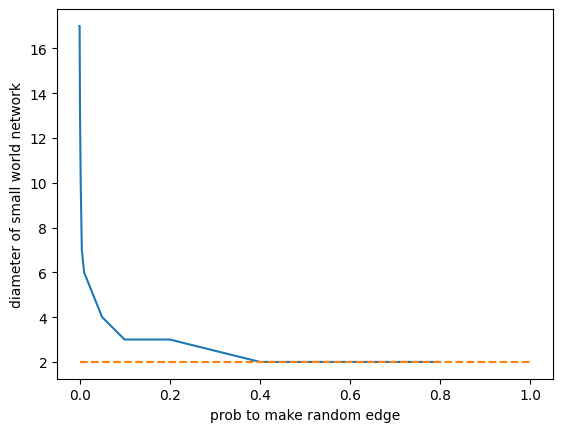

In [6]:
n = 100
P = [0,0.0001,0.001,0.0025,0.005,0.01,0.05,0.1,0.2,0.4,0.6,0.8]
diameters = []
for p in P:
    G = randomnet.small_world_graph(n,6,p)
    # calculate the diameter and store it for plotting below
    single_diameter = nx.diameter(G)
    print(f"{p}: {single_diameter}")
    diameters.append(single_diameter)

## Plot the Convergence
plt.figure()
plt.plot(P,diameters) # change x and y to your "x" and "y" values
plt.plot([0.0001,1],[(np.log10(n)),(np.log10(n))],linestyle = 'dashed')
plt.xlabel('prob to make random edge')
plt.ylabel('diameter of small world network')
plt.show()

### Brief comment on random connections and small world

Firstly we need to define the small world effect. The properties of the small world network is that it has high transitivity and short path lengths. The transitivity is to describe the relation between neighbours, which is the circle network we have seen. The shortest path lengths is highly relying on random connections, since if it is a local model, the diameter is a fixed number `n/2 * 1/(q/2)`. However, if you add random connections between nodes, there are more paths available for the network to travel and shorten the distance from start node to other nodes. And if the `p` is getting larger, which means more random connections are established, the diameter will be shorten faster. This effect is leading to both high transitivity (from local circle network) and short path lengths (from random connections).


## Fitting Power Law

The following helper functions provide easy access to the degree sequence and the degree and cumulative degree distributions.

In [7]:
def degree_sequence(G):
    return [d for n, d in G.degree()]

def degree_distribution(G,normalize=True):
    deg_sequence = degree_sequence(G)
    max_degree = max(deg_sequence)
    ddist = np.zeros((max_degree+1,))
    for d in deg_sequence:
        ddist[d] += 1
    if normalize:
        ddist = ddist/float(G.number_of_nodes())
    return ddist

def cumulative_degree_distribution(G):
    ddist = degree_distribution(G)
    cdist = [ ddist[k:].sum()  for k in range(len(ddist)) ] 
    return cdist

The following function, which you must complete, plots the degree distribution and calculates the power law coefficient, $\alpha$.

In [320]:
def alpha_equation(G, kmin):
    a_tmp = [np.log(ki/(kmin - 0.5)) for ki in degree_sequence(G) if ki>=kmin]
    return 1+len(a_tmp)*(1/sum(a_tmp))

def sigma_equation(G,alpha, kmin):
    a_tmp = [np.log(ki/(kmin - 0.5)) for ki in degree_sequence(G) if ki>=kmin]
    return (alpha - 1) / np.sqrt(len(a_tmp))
def dist_cumu_plots(k, ddist, cdist):

    fig, (ax1, ax2)= plt.subplots(2, figsize=(8,12))
    ax1.bar(k,ddist, width=0.8, bottom=0, color='b') # replace xvalues and barheights!
    
    ax2.loglog(k,cdist, label = 'original') # replace xvalues and yvalues!
    plt.legend() 
    plt.grid(True)
    x = np.log(k)
    y = np.log(cdist)
    m = (y[-1]-y[0])/(x[-1]-x[0])
    b = y[0]-m*x[0]
    ax2.loglog(np.exp(x), np.exp(m*x+b), label = 'linear_fitting')

In [321]:
def calc_powerlaw(G,kmin=None):
    ddist = degree_distribution(G,normalize=True)
    cdist = cumulative_degree_distribution(G)
    k = np.arange(len(ddist))

    alpha = alpha_equation(G, kmin) # calculate using Newman (8.6)!
    sigma = sigma_equation(G, alpha, kmin) # calculate using Newman (8.7)!
    print( 'alpha: %1.2f +/- sigma: %1.2f' % (alpha,sigma) )
    dist_cumu_plots(k[kmin:],ddist[kmin:], cdist[kmin:])
    plt.legend() 
    plt.grid(True)

### Power law plots

The alpha has to be a value between 2 and 3. Thus, it would be the standard for us to choose `kmin`.

alpha: 2.08 +/- sigma: 0.04


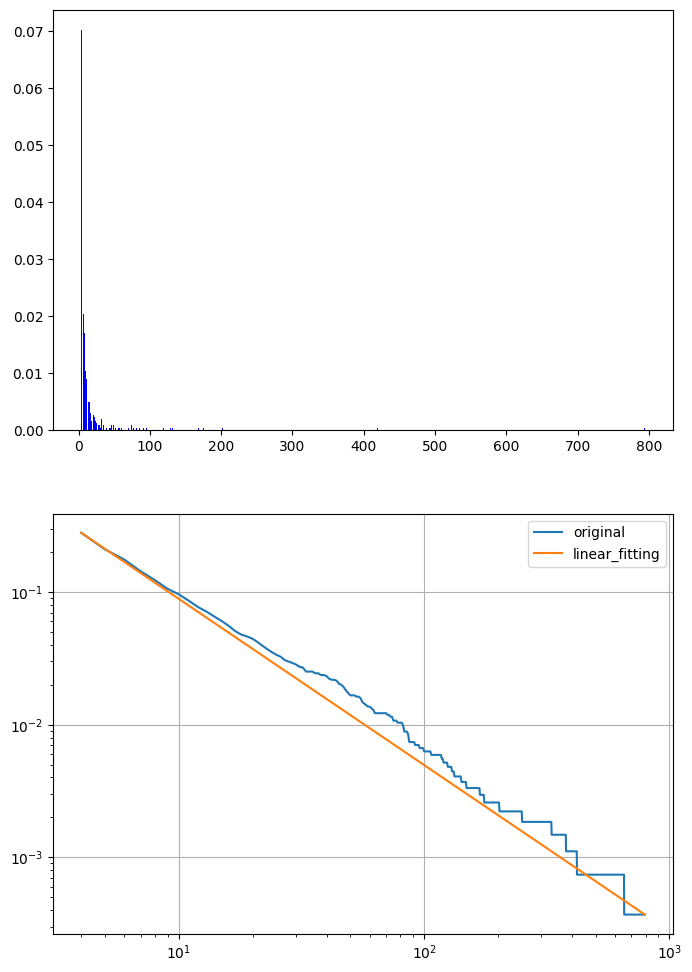

alpha: 2.94 +/- sigma: 0.05


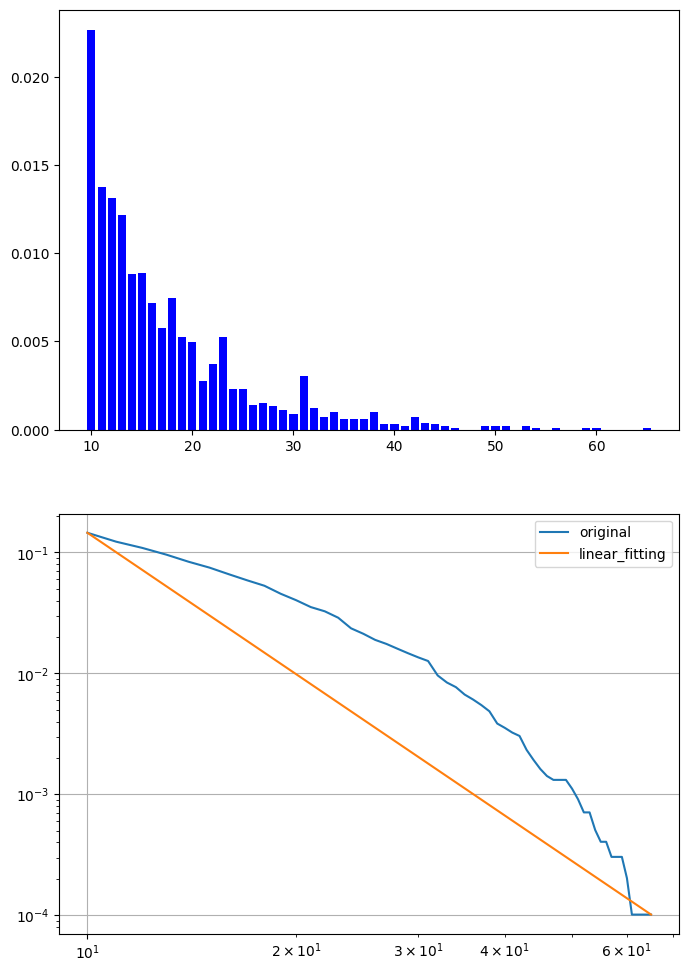

alpha: 2.94 +/- sigma: 0.06


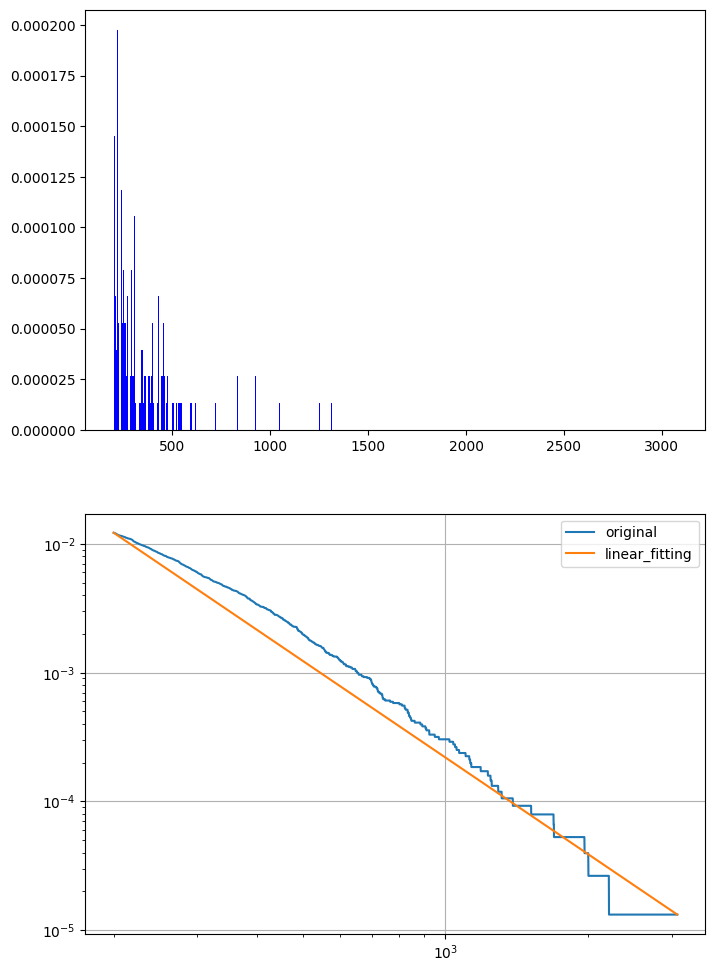

In [322]:

G = nx.read_weighted_edgelist('japanese.edgelist',create_using=nx.DiGraph)
calc_powerlaw(G,kmin=4) # select kmin!
plt.show()
G = nx.read_weighted_edgelist('ca-HepTh.edgelist',create_using=nx.Graph)
calc_powerlaw(G,kmin=10) # select kmin!
plt.show()
G = nx.read_weighted_edgelist('soc-Epinions1.edgelist',create_using=nx.DiGraph)
calc_powerlaw(G,kmin=200) # select kmin!
plt.show()

### Calculate the alpha and sigma

The alpha and sigma have been printed out in my previous session.

My strategy to find the `kmin` is to see if the CDF look straigh on a log-log plot. However, it could be biased so I am not sure if it is a robust method in this question. My answer is that graph 1 and graph 3 are power law distribution, but graph 2 is not. From the graphs, I can find the linear portion from the network 1 and network 3, but I think it's not fitting a line for network 2.

## Giant Component

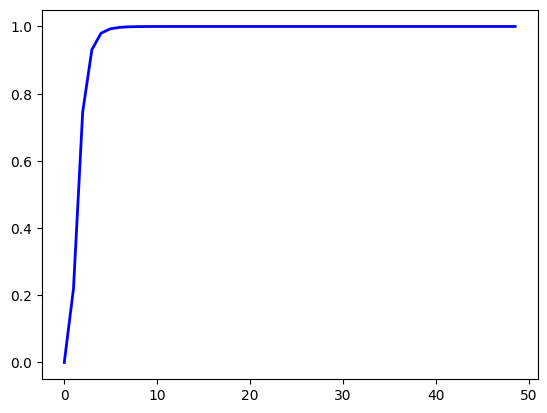

In [25]:
# y axis = giant component
# x axis = average degree
n=100
P = np.arange(0,0.5,0.01)

S_list = []
c_list = []
for p in P:
    rad_net = nx.erdos_renyi_graph(n,p)
    size_largest_comp = len(max(nx.connected_components(rad_net), key=len))
    u = 1- (size_largest_comp/rad_net.number_of_nodes())
    c = (rad_net.number_of_nodes() - 1)*p
    c_list.append(c)
    S= 1-np.exp(-c*(1-u))
    S_list.append(S)



fig = plt.figure()
ax = fig.add_subplot()
ax.plot(c_list, S_list, 'b', linewidth=2)
plt.show()

### Why seeing this non-monotonic behaviors

The `S` represent the fraction of nodes in the giant component. When we increase the `c`, (equation of `c` is `(n-1)*p`) the random connections will have higher probability to be established, which means that there are higher probability a node in the network is belonged to the giant component.

In [194]:
def random_graph_averaging(n, P_range=np.arange(0,0.1,0.001)):
    S_mean = np.array([])
    S_std = np.array([])
    c_list = (n-1)*P_range
    for p in P_range:
        Stmp = np.array([])
        for i in range(10):
            graph = nx.erdos_renyi_graph(n, p)
            size_largest_comp = len(max(nx.connected_components(graph), key=len))
            u= 1-(size_largest_comp/n)
            S= 1-np.exp(-c*(1-u))
            Stmp = np.append(Stmp, S)
        S_mean = np.append(S_mean, Stmp.mean())
        S_std = np.append(S_std, Stmp.std())

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.errorbar(c_list, S_mean, yerr=S_std)
    plt.title(f'n={n}')

### A test graph for my function
when `n=20` and `p` range from 0.001 to 0.1, the convergence of the giant component

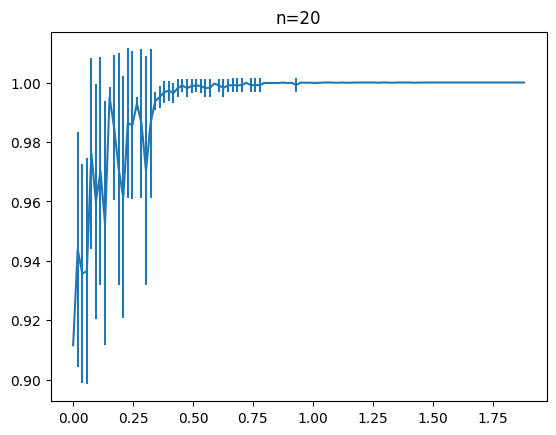

In [195]:
n=20
random_graph_averaging(n)

### Condtion in n=10,100,1000

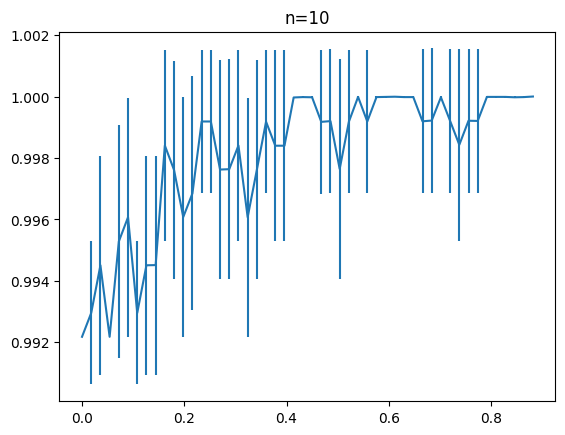

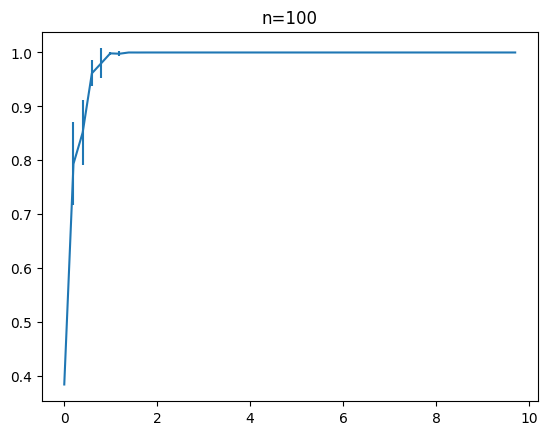

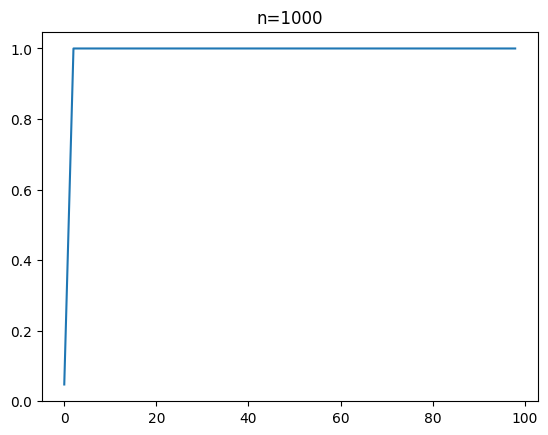

In [47]:
n_list = [10,100,1000]
P_range = np.arange(0,0.1,0.002)
for n in n_list:
    random_graph_averaging(n, P_range)
plt.show()

### Difference in plots & explain convergence
Honestly I am not sure why we need to comment out the n=1000 condition. But I still kept the graph in my assignment.

The statistics of the model converge to their expected values as n gets larger:

I assume the statistics of the model here is the `S`. The general explanation is that, the `c`, expected averaged degree, has a linear relationship with `n` in the equation `(n-1)*p`. Even though `p` is fixed in each condition, when `n` gets larger, the overall averaged degree will still get larger. Each node will have higher averaged degree, which means that it will have high chance to connect with other nodes, when compared to low `n` condition. If the connection probability is higher, it leads to high chance that the node can be connected to the giant component. The definition of `S` is `1-u`, the fraction of nodes in the giant component. Thus, it's not surprised to see in larger `n` condition, the curve will converge sooner with less variance in our graph.


## Degree Distributions of Random Network Models

In [323]:
N = 5000
def network_scaling(N, p=None, q=None, m=None, r=None, s=None, mode='er', kmin=None):
    para = {}
    if mode in ['er','erdos_renyi']:
        G = nx.erdos_renyi_graph(N,p)
        para['p'] = p
    elif mode in ['sm', 'small_world']:
        G = randomnet.small_world_graph(N,q,p)
        para['q'] = q
        para['p'] = p
    elif mode in ['ba','barabasi_albert']:
        G =  nx.barabasi_albert_graph(N,m)
        para['m'] = m
    elif mode in ['la','local_attachment']:
        G = randomnet.local_attachment_graph(N,m,r)
        para['m'] = m
        para['r'] = r
    elif mode in ['dd','duplication_divergence']:
        G = nx.duplication_divergence_graph(N,s)
        para['s']=s
    ddist = degree_distribution(G,normalize=False)
    cdist = cumulative_degree_distribution(G)
    if kmin is None:
        kmin = np.where(ddist>0)[0][0]
    print(f"The power-law exponent is {-alpha_equation(G, kmin=kmin)}")
    k = np.arange(len(ddist))
    dist_cumu_plots(k[kmin:], ddist[kmin:], cdist[kmin:])
    if len(para) > 1:
        fig.suptitle(f"mode = {mode}, {list(para.keys())[0]} = {list(para.values())[0]}, {list(para.keys())[1]} = {list(para.values())[1]}")
    else:
        fig.suptitle(f"mode = {mode}, {list(para.keys())[0]} = {list(para.values())[0]}")
    plt.legend()

### Erdos-Renyi

In each network, I divded the value to three levels: small, medium and large.

I also used different `kmin` in some of the graph to check the linear part.

Not all the graphs are power law distribution. So it's hard to fit all of them into the range `2<= alpha <=3`

The networks with scale-free degree distribution are:
1. barabasi_albert
2. local attachment


The `duplication_divergence` is close to the power law distribution (`alpha` is slightly below 2).

The power-law exponent is -7.008977082993885
The power-law exponent is -31.03123348771608
The power-law exponent is -88.13359382658523


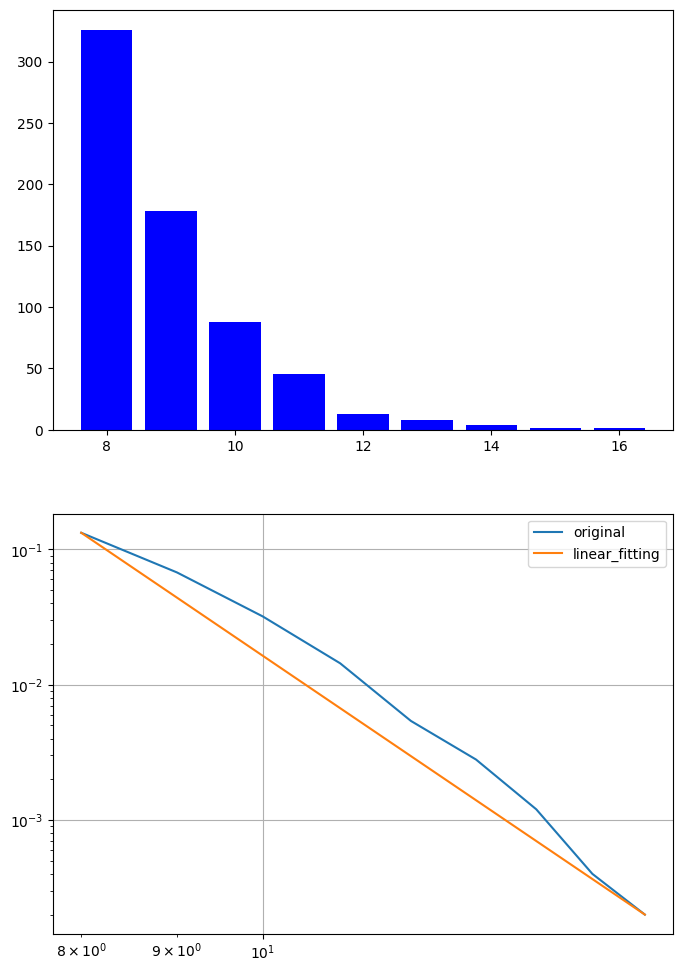

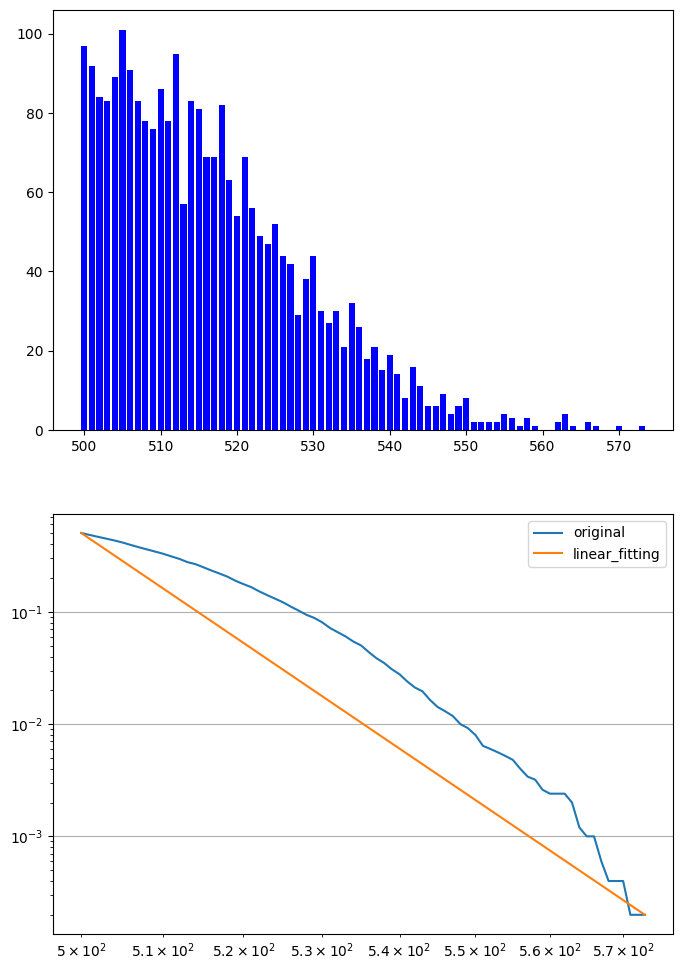

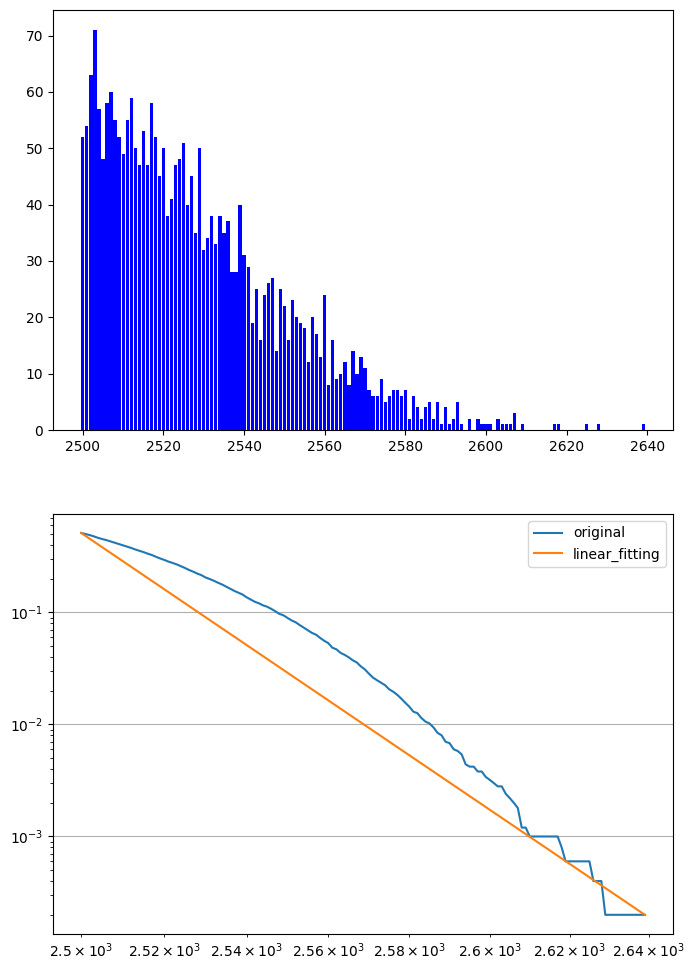

In [324]:
P = [0.001, 0.1, 0.5]
kmin = [8, 500, 2500]
ind = 0
for p in P:
    network_scaling(N, p=p, mode = 'erdos_renyi', kmin=kmin[ind])
    ind+=1

### Small-World

The power-law exponent is -7.096082982103206
The power-law exponent is -11.169610429102137
The power-law exponent is -18.47474908216513
The power-law exponent is -25.995485272708635
The power-law exponent is -20.818766395046953
The power-law exponent is -17.572901897541247
The power-law exponent is -54.20232875227737
The power-law exponent is -49.29635883067879
The power-law exponent is -43.842097629420344


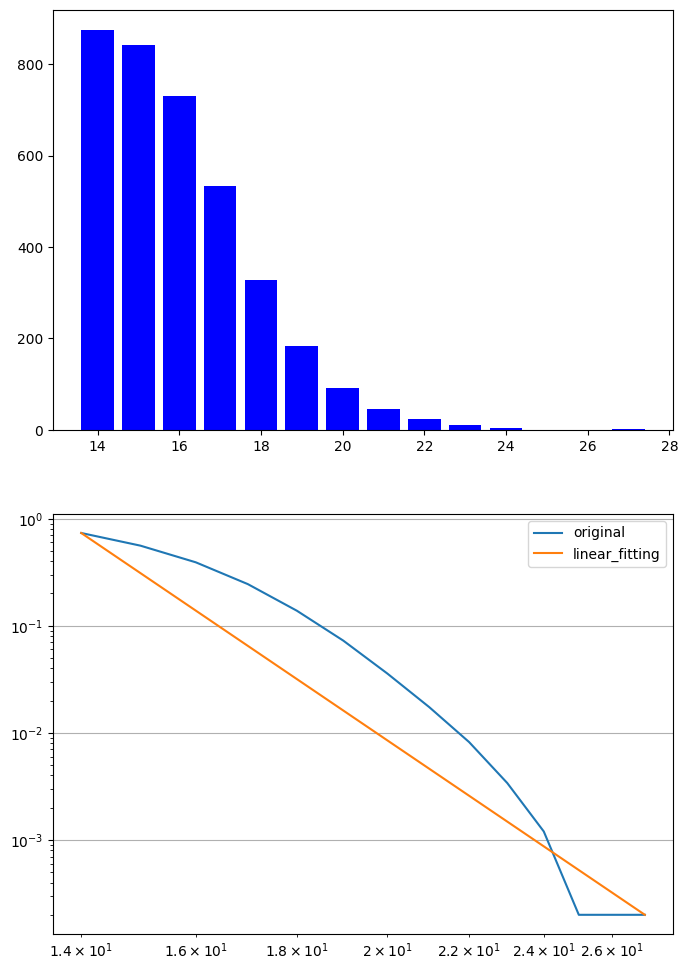

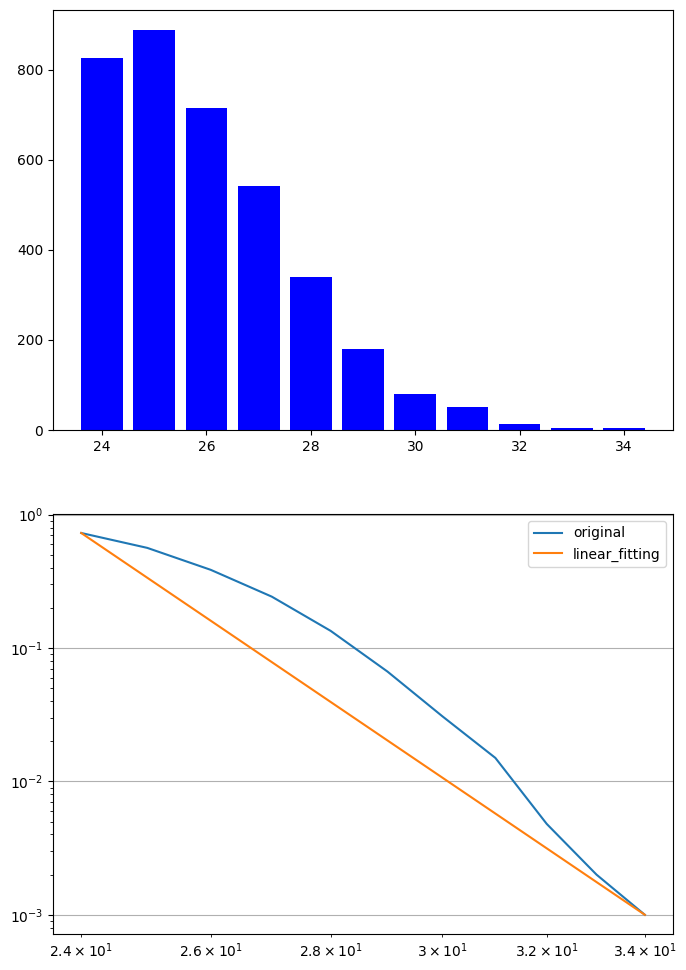

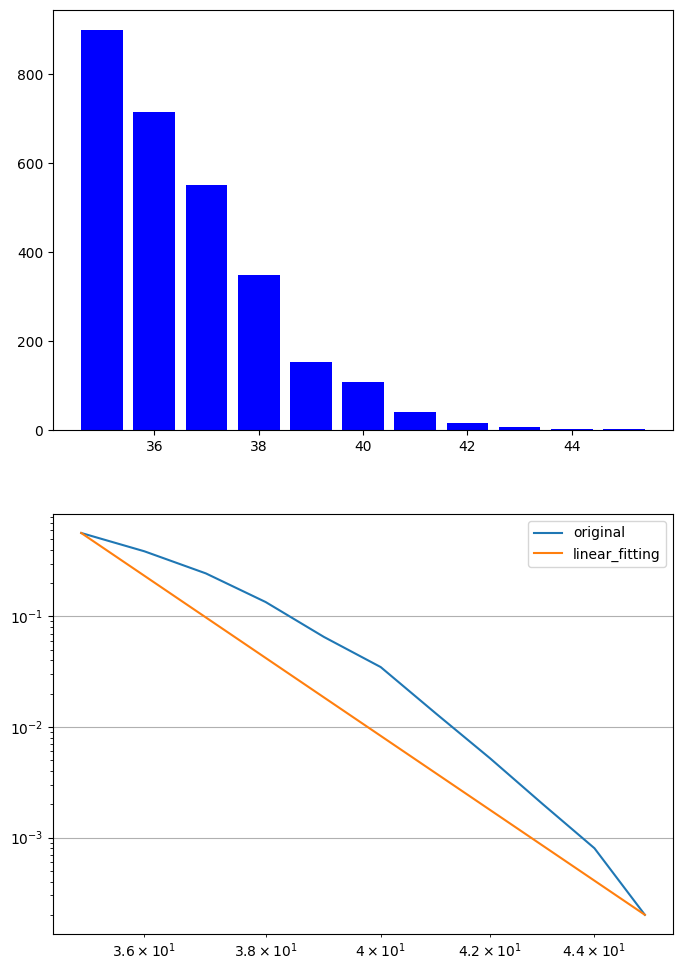

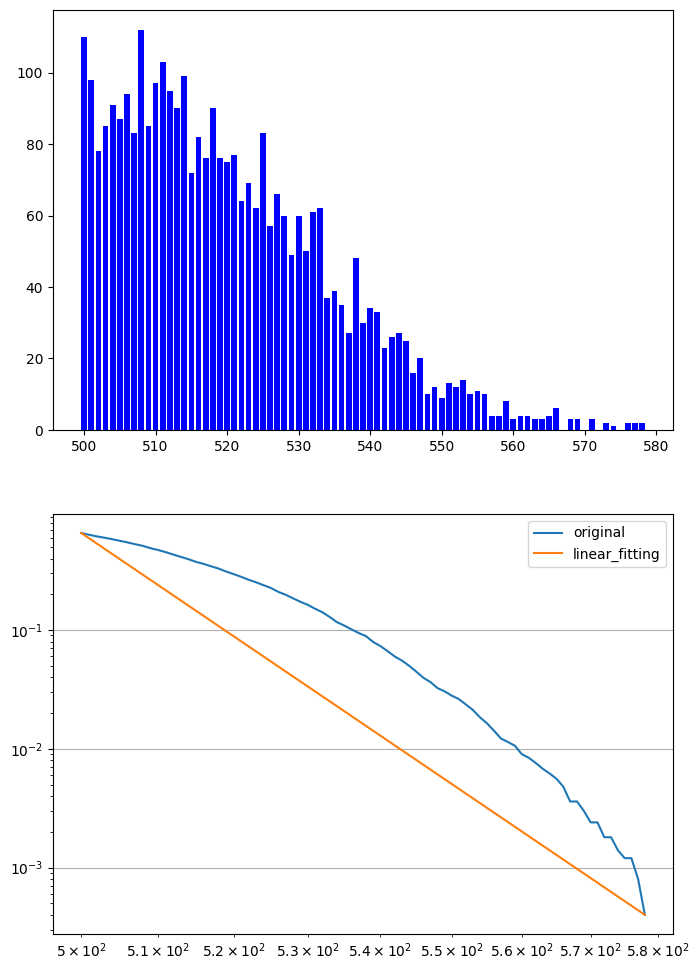

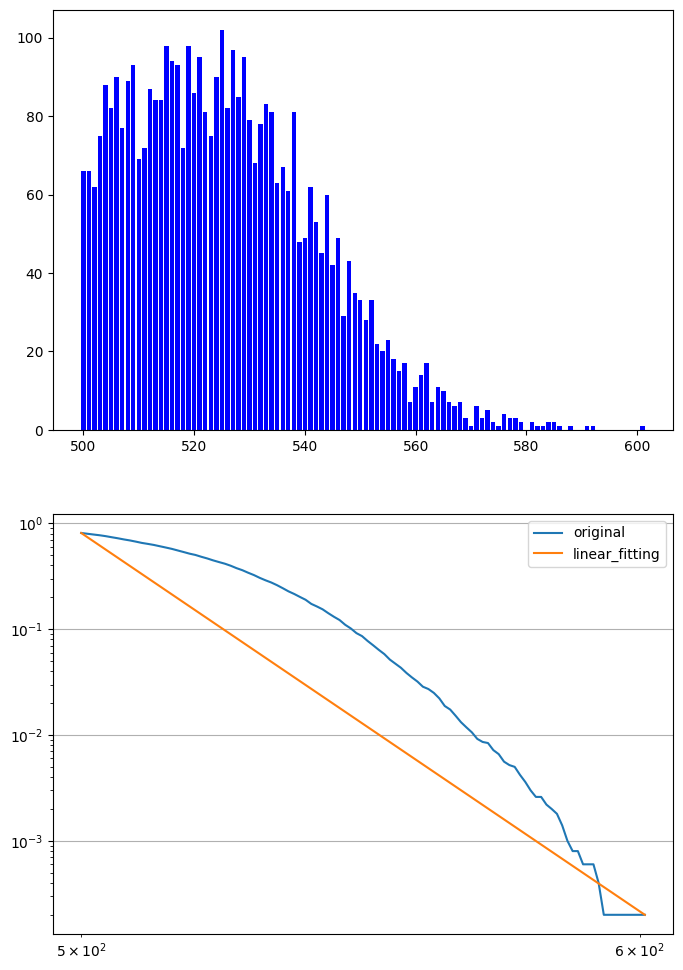

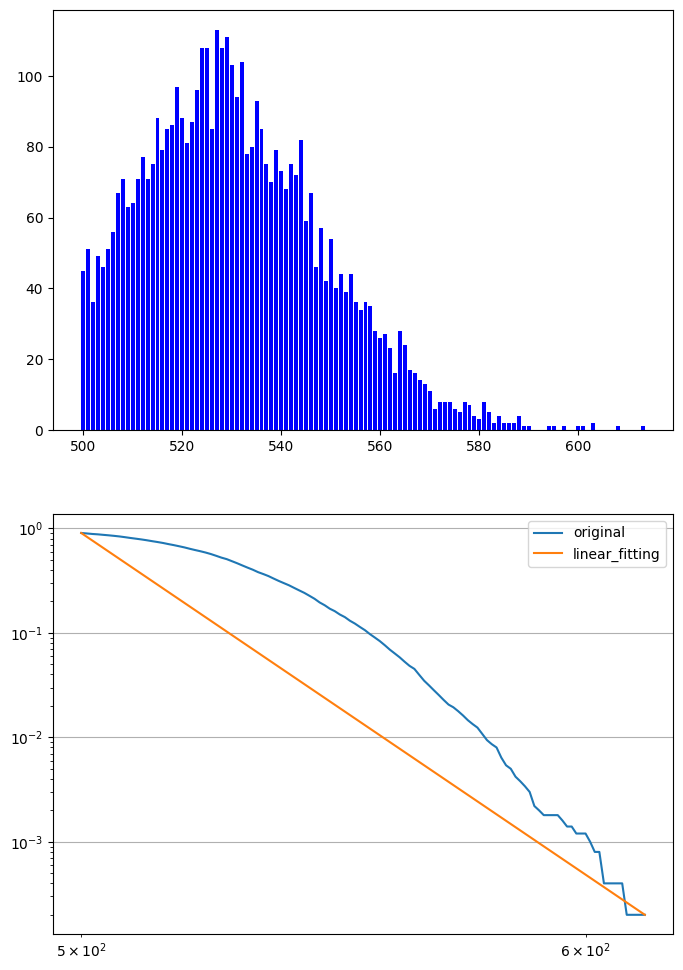

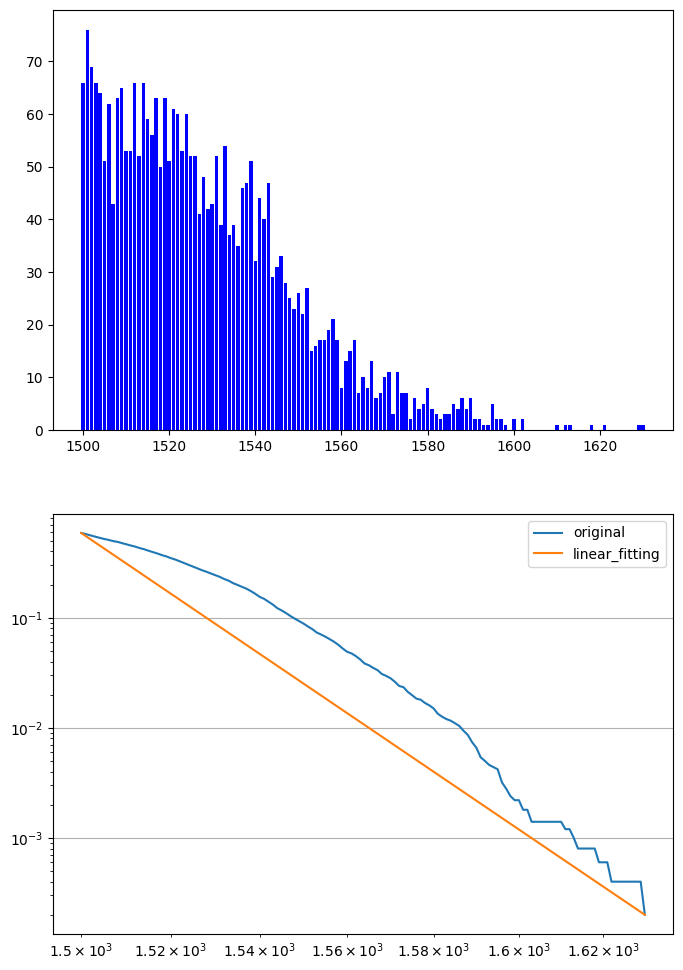

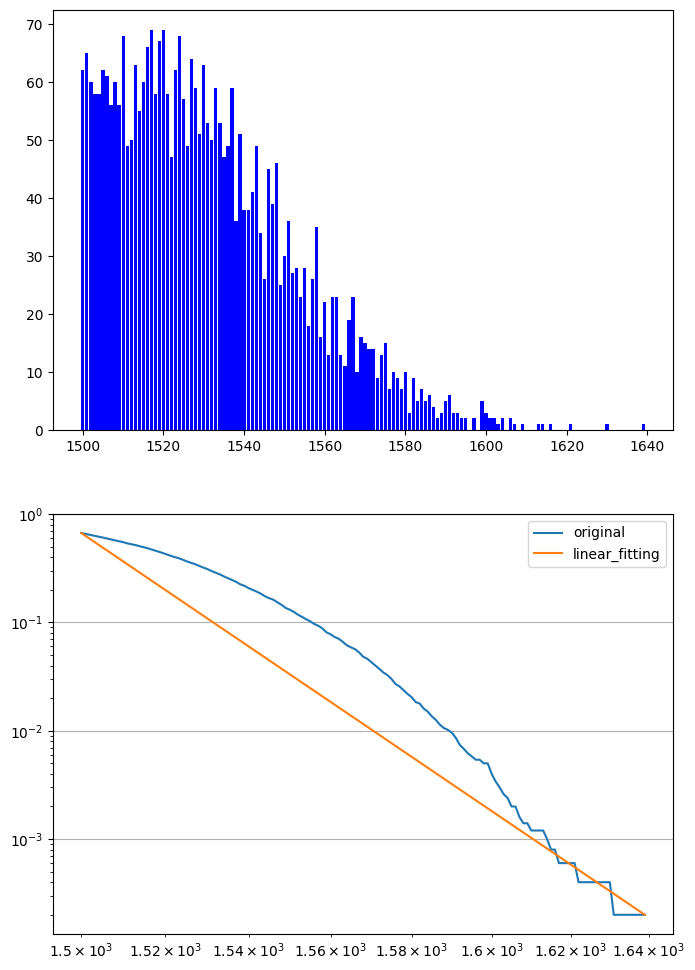

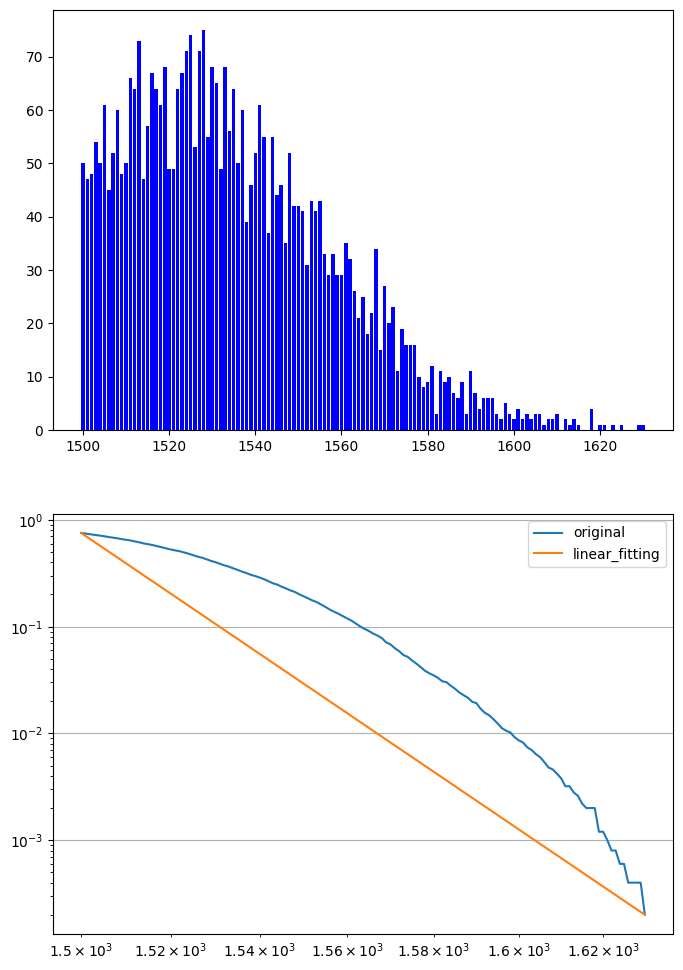

In [325]:
Q = [10,20, 30]
P = [0.001, 0.1, 0.3]
kmin=[14,24,35, 500,500,500,1500,1500,1500]
ind=0
for p in P:
    for q in Q:
        network_scaling(N, p=p, q=q, mode = 'small_world', kmin=kmin[ind])
        ind+=1

### Barabasi-Albert

The power-law exponent is -2.8415930755811907
The power-law exponent is -2.9131909714545254
The power-law exponent is -2.9537280806207233


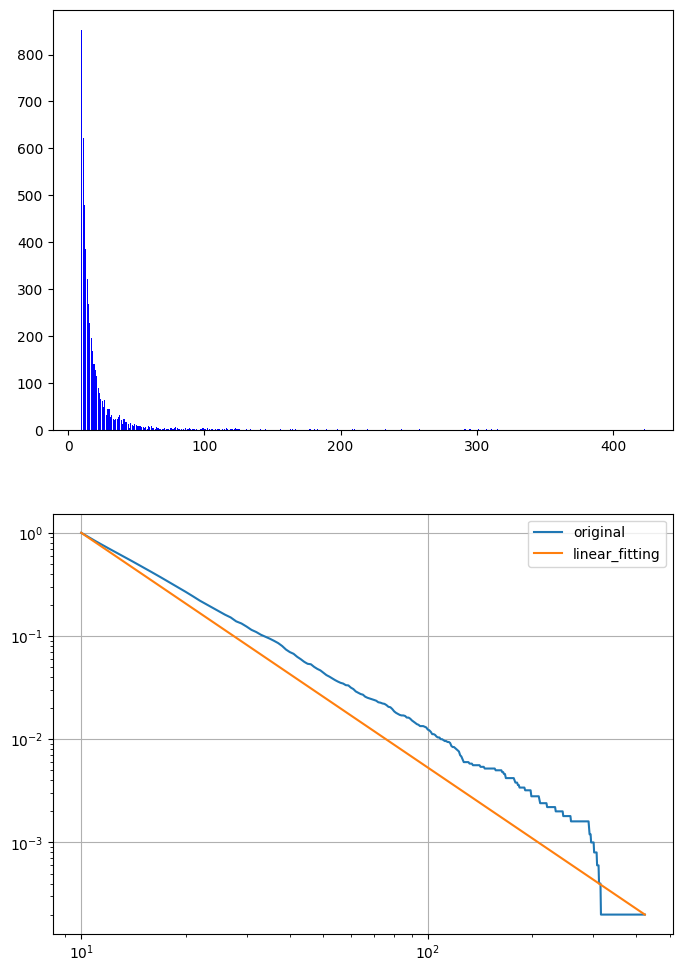

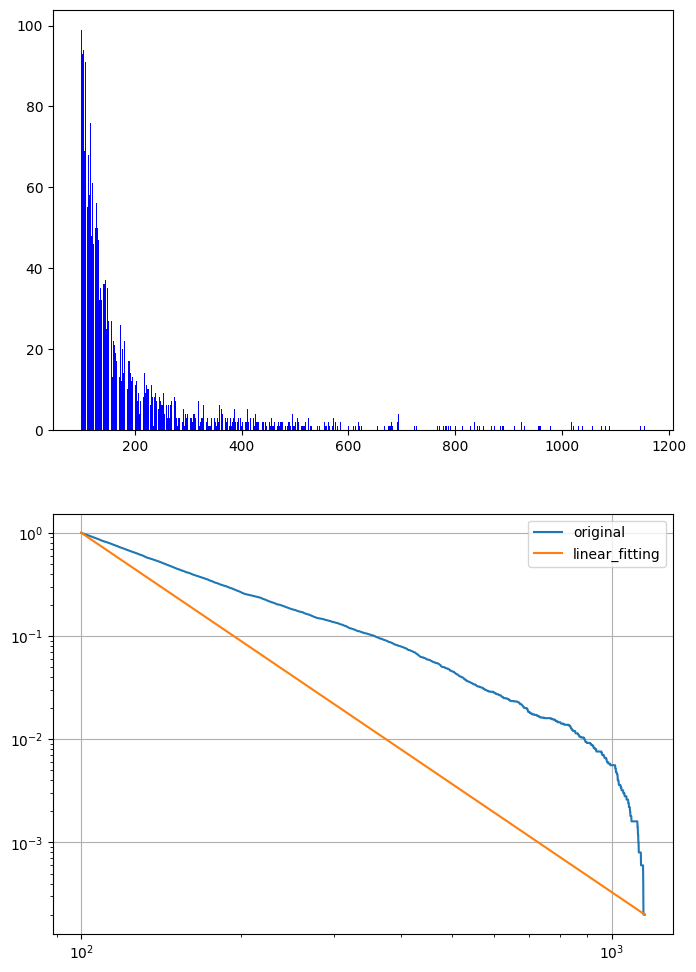

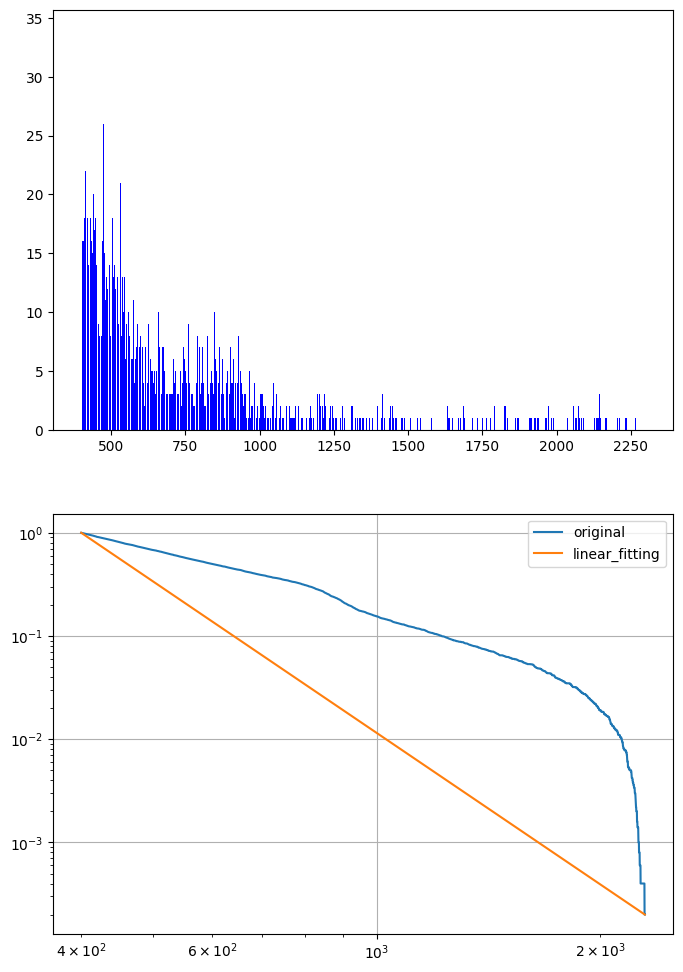

In [326]:
# G = nx.barabasi_albert_graph(N,m)

M = [10, 100, 400]
for m in M:
    network_scaling(N, m=m, mode='barabasi_albert')

### Local Attachment

The power-law exponent is -2.853254439747896
The power-law exponent is -2.7727857591412572
The power-law exponent is -2.715077133760008


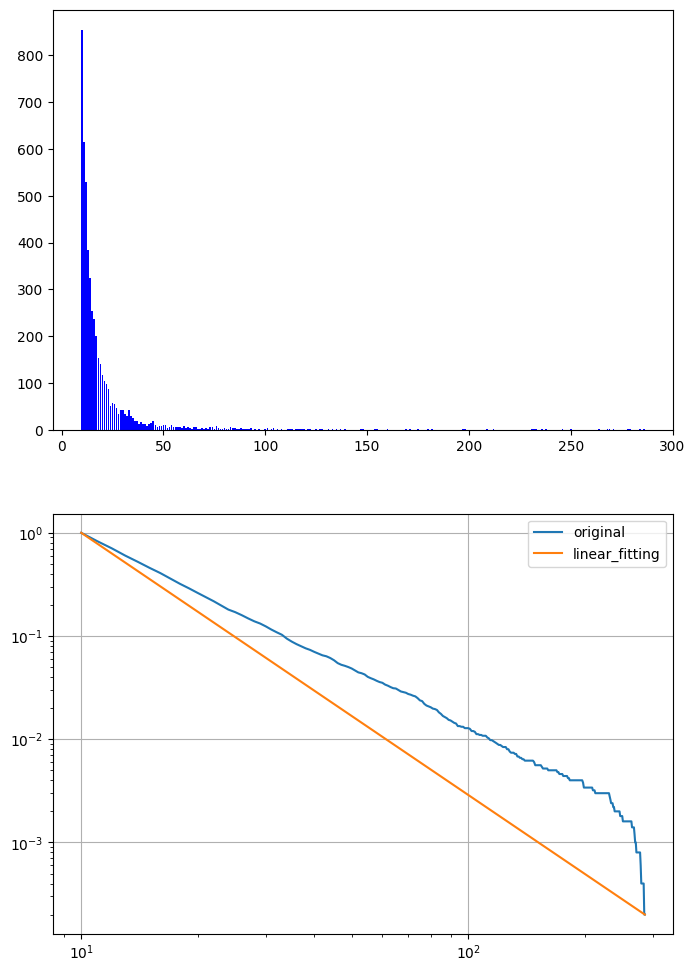

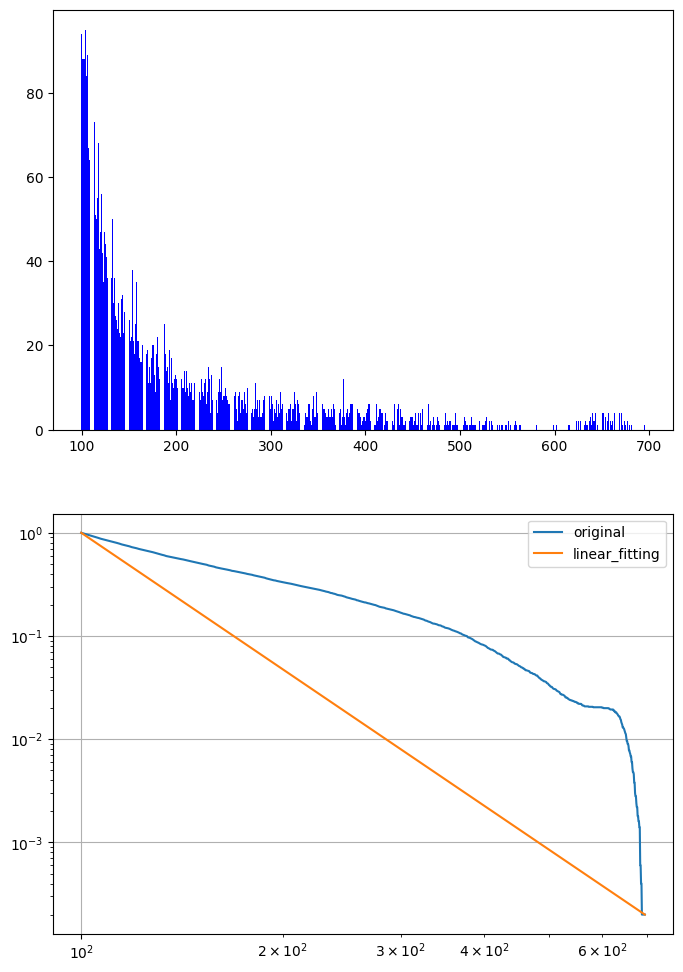

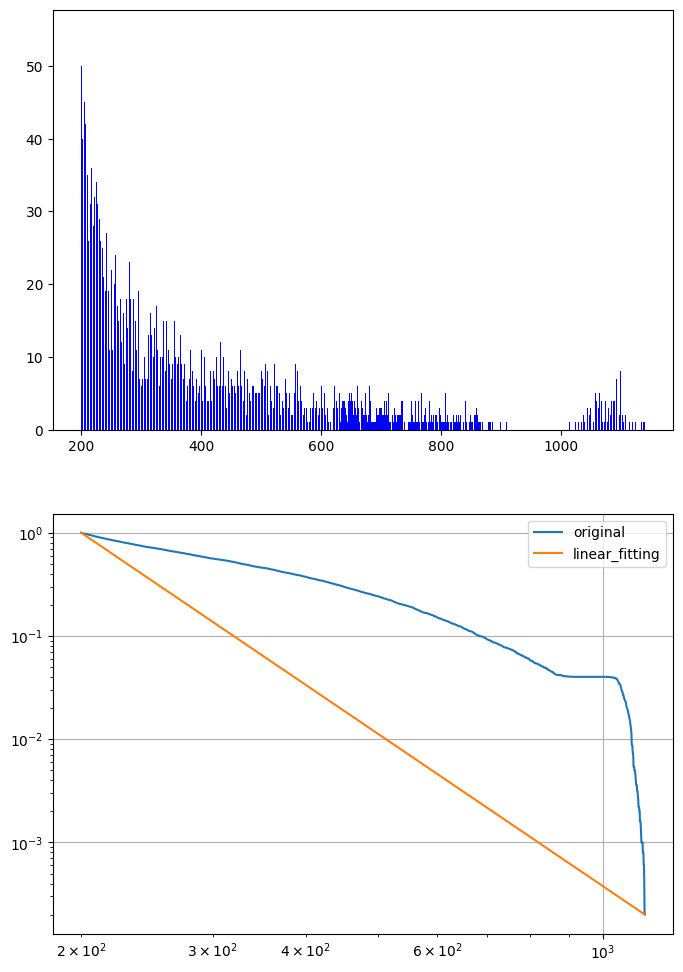

In [327]:
# G = randomnet.local_attachment_graph(N,m,r)

M = [10, 100, 200]
R = [5, 50, 100]

for m,r in zip(M, R):
    network_scaling(N, m=m, r=r, mode='local_attachment')


### Duplication Divergence

The power-law exponent is -1.9205748178478808
The power-law exponent is -1.81389687367249
The power-law exponent is -1.7163924487580258


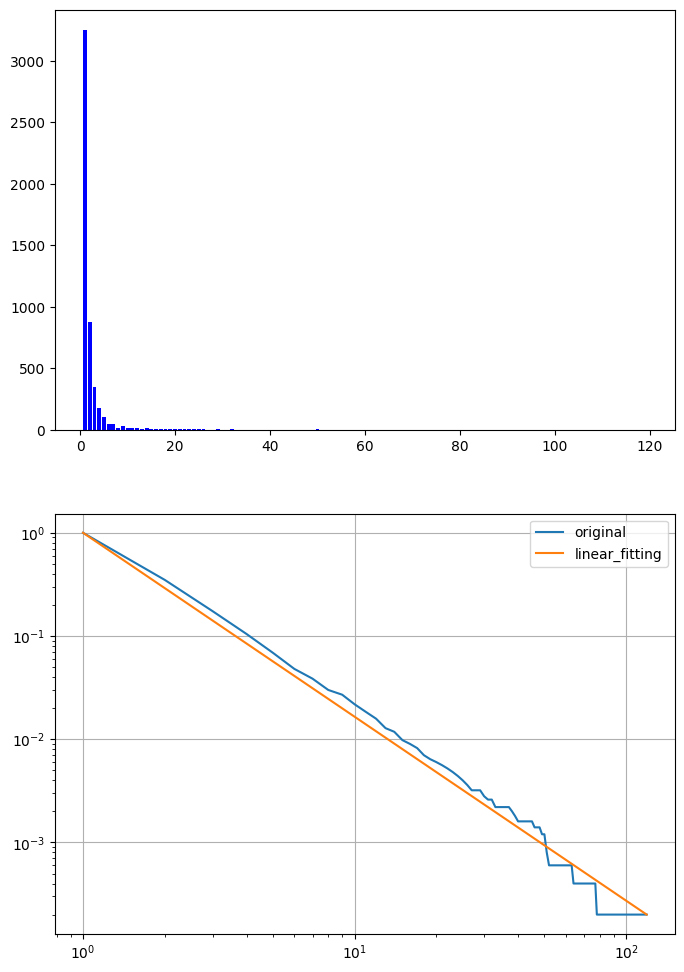

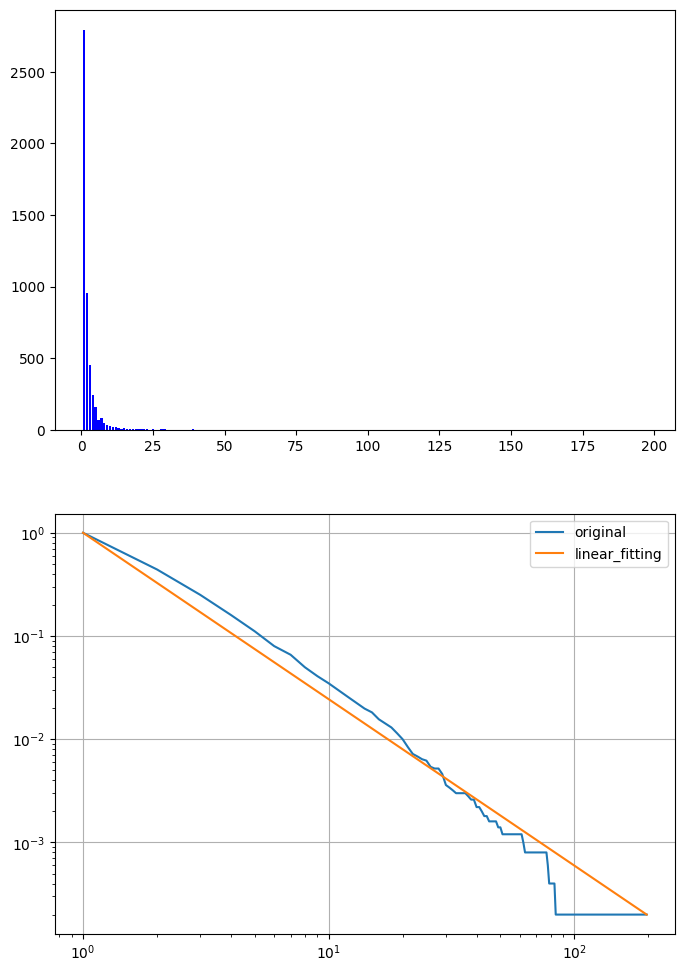

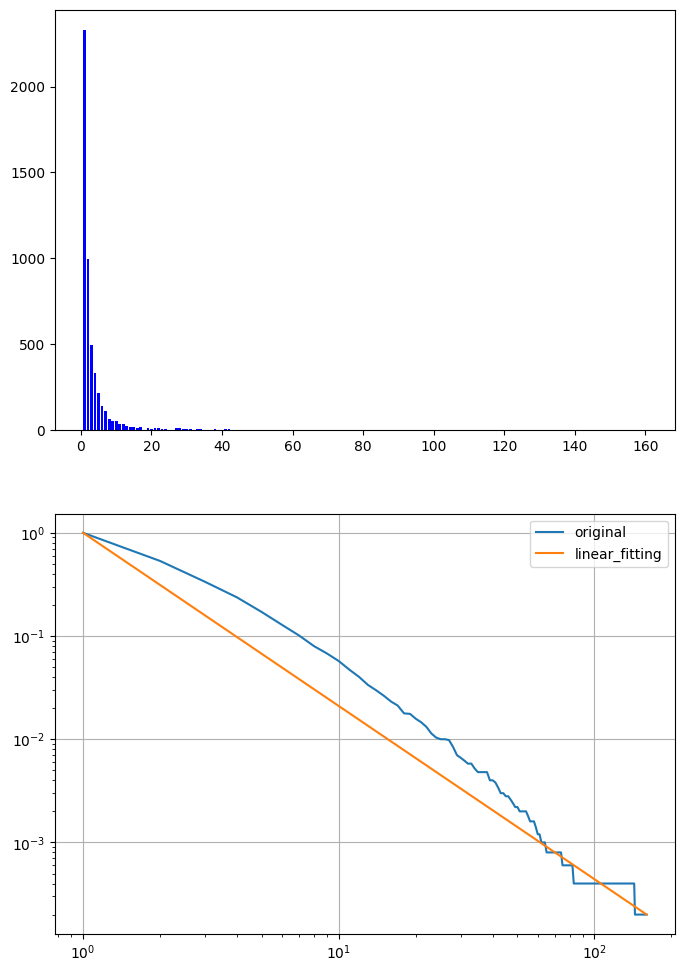

In [328]:
# G = nx.duplication_divergence_graph(N,s)
S = [0.01, 0.1, 0.2]

for s in S:
    network_scaling(N, s=s, mode='duplication_divergence')

## Fitting Random Models

In [329]:
def degree_distribution_plot(G, network_name): 
    ddist = degree_distribution(G)
    cdist = cumulative_degree_distribution(G)
    k = np.arange(len(ddist))
    try:
        kmin = np.where(ddist>0)[0][0]
    except:
        kmin = 1
    dist_cumu_plots(k[kmin:], ddist[kmin:], cdist[kmin:])
    fig.suptitle(network_name)
    plt.grid(True)
    plt.legend()

def network_statistics(G, network_name):
    # Number of Nodes and Edges
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(f"The number of nodes is {n}, the number of edges is {m}")
    # Average degree
    nodes_degree = [G.degree(i) for i in G.nodes()]
    avg_degree = sum(nodes_degree)/G.number_of_nodes()
    print(f"average of the degree is {avg_degree}")
    # Average clustering
    print(f"average of clustering is {nx.average_clustering(G)}")
    # Degree distribution
    degree_distribution_plot(G, network_name)

### Actual Network Statistics

The number of nodes is 9877, the number of edges is 25998
average of the degree is 5.264351523742027
average of clustering is 0.4714390529669332


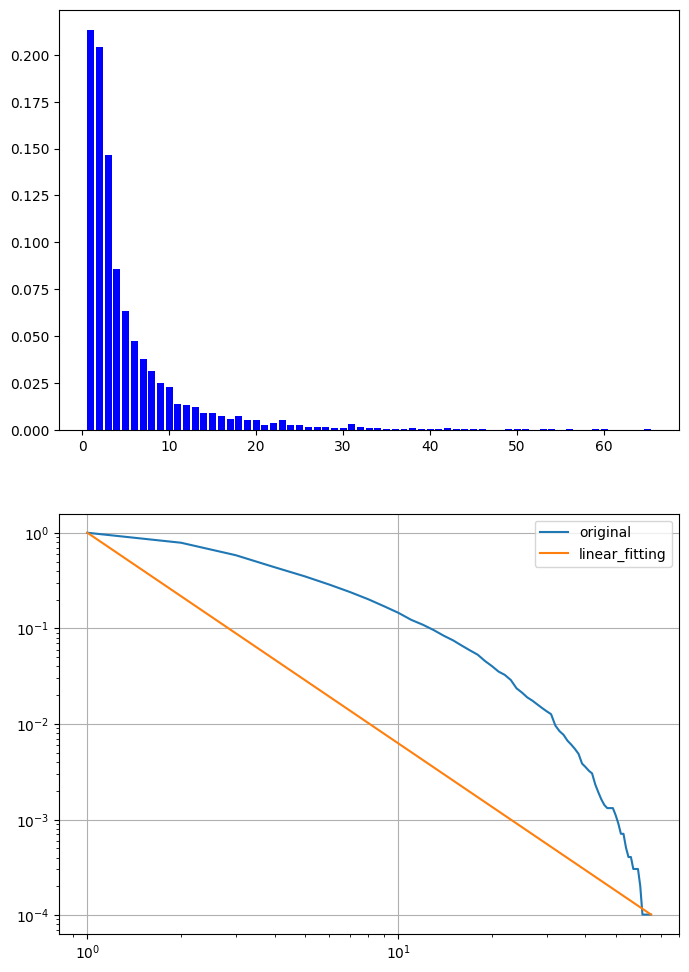

In [330]:
G = nx.read_weighted_edgelist('ca-HepTh.edgelist')
network_statistics(G, 'real_network')


### Fitting Network Statistics

ER graph
The number of nodes is 9877, the number of edges is 487938
average of the degree is 98.80287536701428
average of clustering is 0.009998741191314784
LA graph
The number of nodes is 9877, the number of edges is 987700
average of the degree is 200.0
average of clustering is 0.10217050743283318
DD graph
The number of nodes is 9877, the number of edges is 10134
average of the degree is 2.052040093145692
average of clustering is 0.0
configuration graph
The number of nodes is 9877, the number of edges is 25977
average of the degree is 5.260099220411056
average of clustering is 0.0022759549488035554


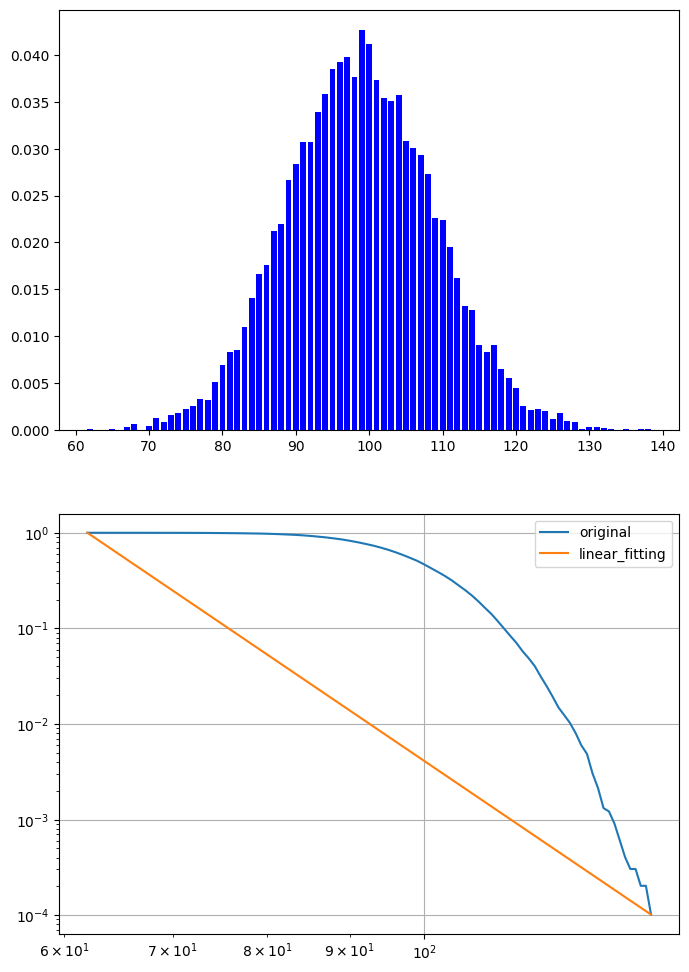

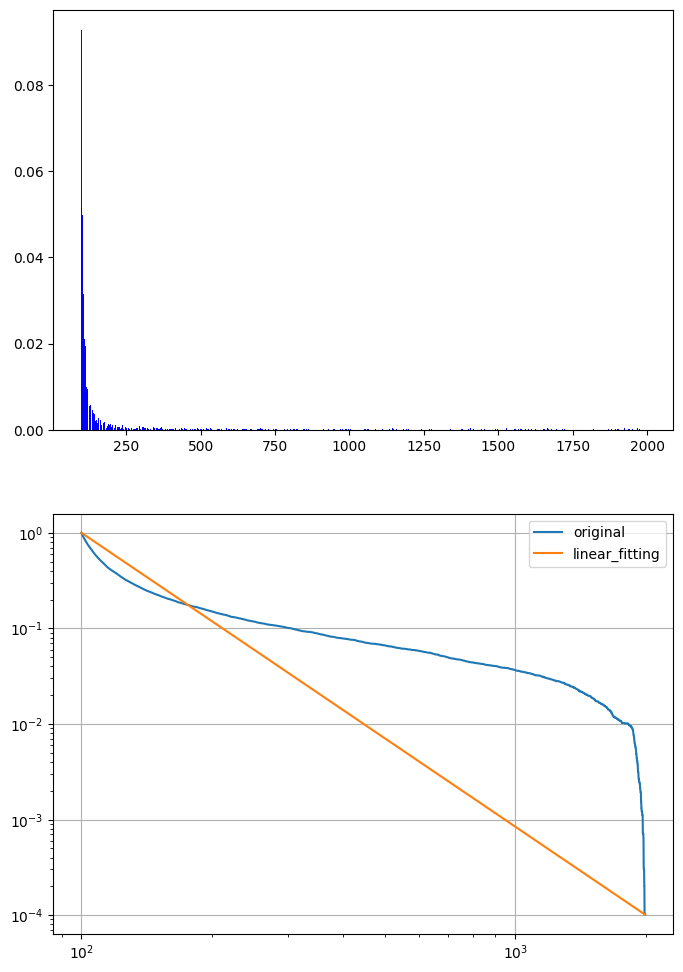

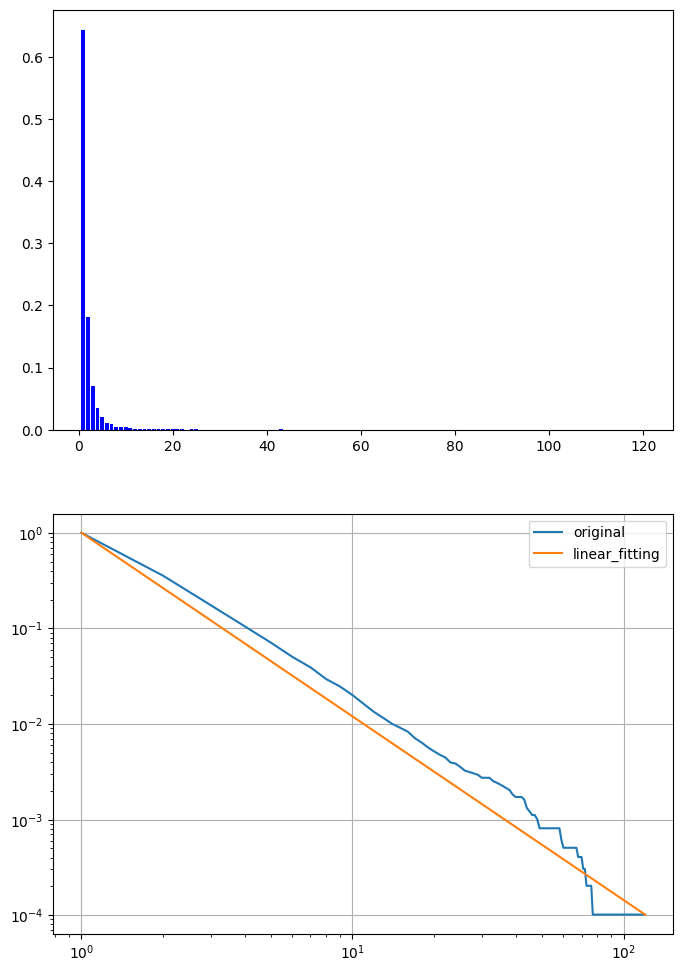

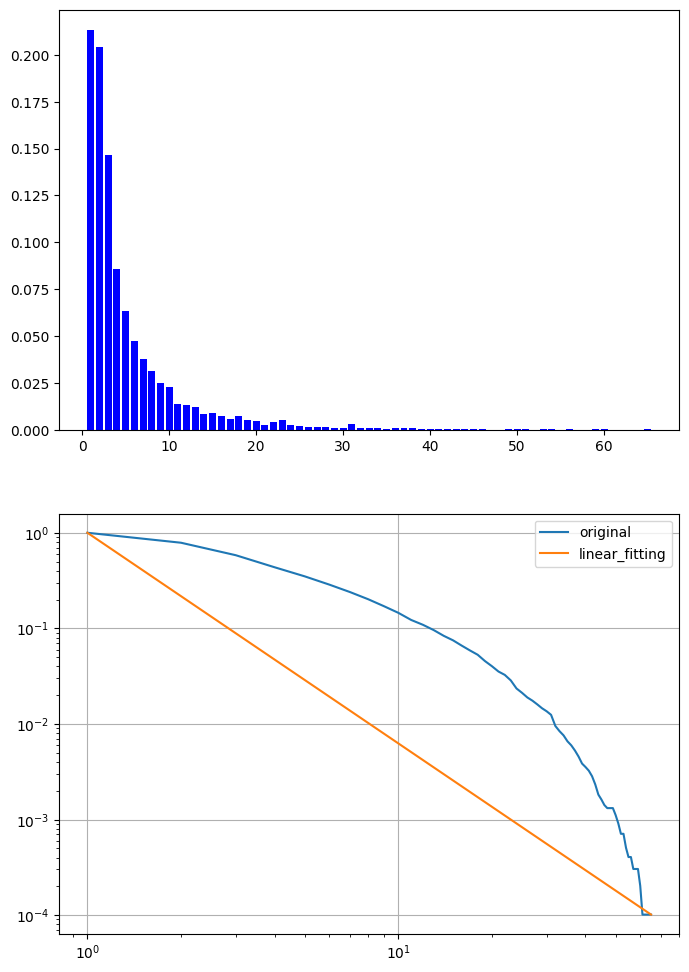

In [331]:
## ER
n= G.number_of_nodes()
p = 0.01
ER_G = nx.erdos_renyi_graph(n,p)
print("ER graph")
network_statistics(ER_G, "ER_graph")
## LA
m = 100
r = 10
LA_G = randomnet.local_attachment_graph(n,m,r)
print('LA graph')
network_statistics(LA_G, "LA_graph")
## DD
p = 0.01
DD_G = randomnet.duplication_divergence_graph(n,p)
print("DD graph")
network_statistics(DD_G, "DD_graph")
## Configuration model
config_model_G = nx.configuration_model(degree_sequence(G), create_using=nx.Graph())
print("configuration graph")
network_statistics(config_model_G, "configuration_model_graph")

## Configuration Model

In [332]:
def average_degree_neigh(G):
    # Average degree of the network:
    avg_degree = sum(degree_sequence(G))/G.number_of_nodes()
    # Average degree of neighbor nodes:
    avg_neighbors = []
    for i in G.nodes():
        neigh_nodes = [ij for ij in G.neighbors(i)]
        single_node_neigh_degree = [G.degree(j) for j in neigh_nodes]
        avg_neighbors.append(sum(single_node_neigh_degree)/len(neigh_nodes))
    avg_neigh = np.mean(avg_neighbors)
    print(f"average of the degree is {avg_degree}; average of the degree from neighbors is {avg_neigh}")


G = nx.read_weighted_edgelist('texas_road_sample.edgelist')
print('texas road map')
average_degree_neigh(G)
G = nx.read_weighted_edgelist('international_airports.edgelist')
print('international airport')
average_degree_neigh(G)



texas road map
average of the degree is 2.498556304138595; average of the degree from neighbors is 2.973788899582932
international airport
average of the degree is 10.668254508336169; average of the degree from neighbors is 45.069840918826


### Explain why
In the texas road network, each node only have really limited degree to other nodes (restricted by physical distance and construction space). The differences of degree between nodes are not really huge.

However, in the international airport network, the number of airlines could be much higher than highway road. Also, there exists a "richer get richer" effect: the largest the airport, the higher capacity that the airport has airline to other places. There are much higher chance for an airport to connect to a huge international airport than a road to connect to a traffic hub in the Texas road map example. Without the restriction in physical land and space, one airport can also have much more airlines connections with other airports. All these factors explain why the average degree and average neighbor degree are higher in airline network. Also, in airline network, if one airport connects to a huge international airport, the degree of neighbor would be much higher. And just like what I mentioned, a huge internation airport are more likely to be connected to others, which will make the degree of neighbour goes higher in airline network.